In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [2]:
data_raw = pd.read_csv("marketing_campaign.csv", sep="\t")
data = data_raw.copy()

In [3]:
data = data.drop(columns=["ID", "Z_CostContact", "Z_Revenue"])

In [5]:
data['Income'] = data['Income'].fillna(data['Income'].median())

In [6]:
data["Age"] = 2025 - data["Year_Birth"]

In [27]:
data['Age'].unique()

array([ 68,  71,  60,  41,  44,  58,  54,  40,  51,  75,  42,  49,  66,
        73,  38,  79,  45,  76,  43,  46,  74,  56,  39,  36,  62,  55,
        52,  82,  50,  29,  57,  61,  48,  47,  70,  59,  37,  77,  67,
        53,  65,  80,  34,  63,  72,  64,  69,  33, 125, 132,  35,  78,
       126,  32,  31,  84,  81,  30,  85])

In [ ]:
data['Age']

In [7]:
data["Family_Size"] = data["Kidhome"] + data["Teenhome"]

In [8]:
spend_features = ["MntWines","MntFruits","MntMeatProducts",
                  "MntFishProducts","MntSweetProducts","MntGoldProds"]
data["TotalSpend"] = data[spend_features].sum(axis=1)

In [9]:
purchase_features = ["NumDealsPurchases","NumWebPurchases",
                     "NumCatalogPurchases","NumStorePurchases"]
data["TotalPurchases"] = data[purchase_features].sum(axis=1)


In [10]:
X = data[["Income", "TotalSpend"]].copy()

In [11]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

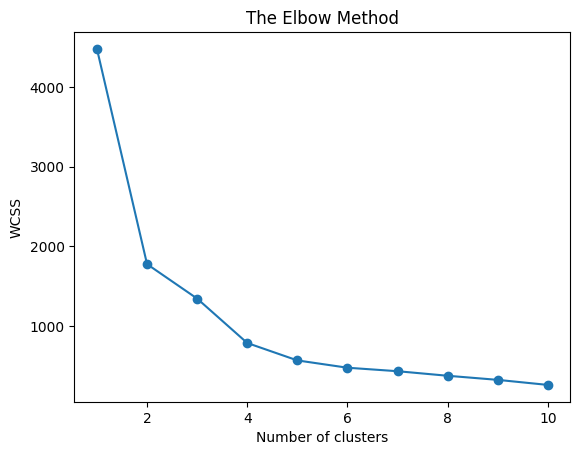

In [12]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss, marker="o")
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [15]:
kmeans = KMeans(n_clusters=4, init="k-means++", random_state=42)
labels = kmeans.fit_predict(scaled_data)


In [16]:
print("Silhouette Score (KMeans):", silhouette_score(scaled_data, labels))

Silhouette Score (KMeans): 0.5054086308480474


In [17]:
data["Cluster"] = labels

In [18]:
cluster_means = data.groupby("Cluster")[["Age","Income","TotalSpend","TotalPurchases"]].mean()

In [19]:
cluster_sizes = data["Cluster"].value_counts().sort_index()

In [20]:
edu_dist = (data.groupby("Cluster")["Education"]
               .value_counts(normalize=True)
               .unstack(fill_value=0).round(2))

In [21]:
marital_dist = (data.groupby("Cluster")["Marital_Status"]
                  .value_counts(normalize=True)
                  .unstack(fill_value=0).round(2))

In [22]:
cluster_profile = pd.concat([cluster_means, cluster_sizes.rename("Count")], axis=1)
cluster_profile = cluster_profile.join(edu_dist, how="left", rsuffix="_edu")
cluster_profile = cluster_profile.join(marital_dist, how="left", rsuffix="_marital")

In [23]:
print("\n=== Cluster Profile ===")
print(cluster_profile)


=== Cluster Profile ===
               Age         Income   TotalSpend  TotalPurchases  Count  \
Cluster                                                                 
0        59.040000   63393.070769   767.216923       20.844615    650   
1        56.975877   77983.115132  1570.635965       21.364035    456   
2        54.254192   34934.335834   125.353045        8.816417   1133   
3        48.000000  666666.000000    62.000000       11.000000      1   

         2n Cycle  Basic  Graduation  Master   PhD  Absurd  Alone  Divorced  \
Cluster                                                                       
0            0.08   0.00        0.51    0.17  0.24     0.0    0.0      0.12   
1            0.07   0.00        0.52    0.16  0.25     0.0    0.0      0.10   
2            0.11   0.05        0.49    0.17  0.19     0.0    0.0      0.10   
3            0.00   0.00        1.00    0.00  0.00     0.0    0.0      0.00   

         Married  Single  Together  Widow  YOLO  
Cluster    

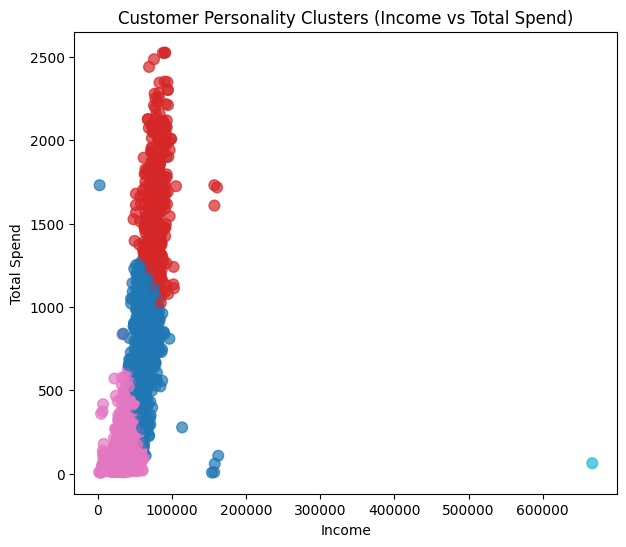

In [24]:
plt.figure(figsize=(7,6))
plt.scatter(data["Income"], data["TotalSpend"], 
            c=data["Cluster"], cmap="tab10", s=60, alpha=0.7)
plt.xlabel("Income")
plt.ylabel("Total Spend")
plt.title("Customer Personality Clusters (Income vs Total Spend)")
plt.show()

In [25]:
cluster_labels = {
    0: "High Income, High Spend → Premium Spenders",
    1: "Low Income, Low Spend → Thrifty Customers",
    2: "Mid Income, High Spend → Value Seekers",
    3: "Young, Low Spend → Budget Explorers",
    4: "Older, Mid Spend → Traditional Customers"
}

# Add labels to profile
cluster_profile = cluster_profile.copy()
cluster_profile["Segment"] = cluster_profile.index.map(cluster_labels)


In [26]:
print("\n=== Cluster Profile with Segments ===")
print(cluster_profile[["Age","Income","TotalSpend","TotalPurchases","Count","Segment"]])


=== Cluster Profile with Segments ===
               Age         Income   TotalSpend  TotalPurchases  Count  \
Cluster                                                                 
0        59.040000   63393.070769   767.216923       20.844615    650   
1        56.975877   77983.115132  1570.635965       21.364035    456   
2        54.254192   34934.335834   125.353045        8.816417   1133   
3        48.000000  666666.000000    62.000000       11.000000      1   

                                            Segment  
Cluster                                              
0        High Income, High Spend → Premium Spenders  
1         Low Income, Low Spend → Thrifty Customers  
2            Mid Income, High Spend → Value Seekers  
3               Young, Low Spend → Budget Explorers  
